This project is written by Rui Bai(rb3454) and Yichi Liu (yl4327). The logic is based on the [paper](https://arxiv.org/abs/1703.02442). We used data from [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) which contains several slides from [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset.

This script will run the model based on the extracted patches.

We've tried Resnet 50 and InceptionV3 as the base model. Resnet 50 performed worse than InceptionV3. Hence, it is not included in the script. Both single zoom level and multi zoom level mode is included in the script. 

The training process output of the model is not included since the model we chose as our final model is trained before. The model is saved and the plots for the training process is in the **Slides/ Video**.

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

import random
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf



In [ ]:
BATCH_SIZE = 32
PATCH_SIZE = 299
CENTER_SIZE = 128

multi_levels = [1,2]

levels = 'level12'
level1 = 'level1'
level2 = 'level2'

# training and validation directory
train_dir_l1 = '/content/gdrive/My Drive/applied deep learning/final pj/'+levels + '/' + level1+'/train'
train_dir_l2 = '/content/gdrive/My Drive/applied deep learning/final pj/'+levels + '/' + level2+'/train'
val_dir_l1 = '/content/gdrive/My Drive/applied deep learning/final pj/'+levels + '/' + level1+'/validation'
val_dir_l2 = '/content/gdrive/My Drive/applied deep learning/final pj/'+levels + '/' + level2+'/validation'


# Model saving directory
result_save_dir = '/content/gdrive/My Drive/applied deep learning/final pj/result'
## single scale model based on Inception V3 with transfer learning 
single_scale_inception_model_fix_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_fix.h5'
single_scale_inception_model_fix_history_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_fix_history.csv'
single_scale_inception_model_fix_plot_acc_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_fix_acc.png'
single_scale_inception_model_fix_plot_loss_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_fix_loss.png'

## single scale model based on Inception V3 with fine-tuning
single_scale_inception_model_unfix_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_unfix.h5'
single_scale_inception_model_unfix_history_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_unfix_history.csv'
single_scale_inception_model_unfix_plot_acc_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_unfix_acc.png'
single_scale_inception_model_unfix_plot_loss_save = result_save_dir + '/models/'+level1+'_single_scale_inception_model_unfix_loss.png'

## multi scale model based on Inception V3 with transfer learning 
multi_scale_inception_model_fix_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_fix.h5'
multi_scale_inception_model_fix_history_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_fix_history.csv'
multi_scale_inception_model_fix_plot_acc_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_fix_acc.png'
multi_scale_inception_model_fix_plot_loss_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_fix_loss.png'

## multi scale model based on Inception V3 with fine-tuning 
multi_scale_inception_model_unfix_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_unfix.h5'
multi_scale_inception_model_unfix_history_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_unfix_history.csv'
multi_scale_inception_model_unfix_plot_acc_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_unfix_acc.png'
multi_scale_inception_model_unfix_plot_loss_save = result_save_dir + '/models/'+levels+'_multi_scale_inception_model_unfix_loss.png'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Create data generators

In [ ]:
# define a function to rotate the image by  0, 90 or 180 or 270 degrees.
def orthogonal_rot(image):
  return np.rot90(image, np.random.choice([0, 1, 2, 3]))

# resize and add data augmentation for training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # rotation_range=40,
    width_shift_range= 8,
    height_shift_range= 8,
    # zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip = True,
    preprocessing_function=orthogonal_rot)

# resize validation data
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
# data generator for single scale
train_generator_single_scale = train_datagen.flow_from_directory(train_dir_l1, batch_size = BATCH_SIZE, shuffle=True, target_size=(PATCH_SIZE, PATCH_SIZE))
val_generator_single_scale = val_datagen.flow_from_directory(val_dir_l1, batch_size = BATCH_SIZE, shuffle=True, target_size=(PATCH_SIZE, PATCH_SIZE))

# data generator for multi scale
def generator_directory_two_scale(dir_l1, dir_l2, batch_size, gen):
    genX1 = gen.flow_from_directory(dir_l1, batch_size=batch_size, seed=1, target_size=(PATCH_SIZE, PATCH_SIZE))
    genX2 = gen.flow_from_directory(dir_l2, batch_size=batch_size, seed=1, target_size=(PATCH_SIZE, PATCH_SIZE))
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

train_generator_two_scale = generator_directory_two_scale(train_dir_l1, train_dir_l2, BATCH_SIZE, train_datagen)
val_generator_two_scale = generator_directory_two_scale(val_dir_l1, val_dir_l2, BATCH_SIZE, val_datagen)

Found 2560 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


In [ ]:
# check 
for (img1, img2),label in train_generator_two_scale:
  break

Found 2560 images belonging to 2 classes.
Found 2560 images belonging to 2 classes.


In [ ]:
print(train_generator_single_scale.class_indices)

{'0': 0, '1': 1}


## Models

In [ ]:
def plot(history,acc_path, loss_path):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig(acc_path)

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(loss_path)


### Single scale model



#### transfer learning model


##### set model

In [ ]:
## COULD write into functions to test other model: We've also tested Resnet50 as base model
inception_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(PATCH_SIZE, PATCH_SIZE, 3))
inception_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
single_scale_inception_model = tf.keras.Sequential([
  inception_model,
  global_average_layer,
  prediction_layer])

single_scale_inception_model.compile(optimizer='adam',
              # loss='categorical_crossentropy',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# add early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
single_scale_inception_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
history = single_scale_inception_model.fit(
    train_generator_single_scale, validation_data=val_generator_single_scale, epochs=20, callbacks = [callback])

In [ ]:
# save model
single_scale_inception_model.save(single_scale_inception_model_fix_save)

# save history
hist_df = pd.DataFrame(history.history) 
hist_csv_file = single_scale_inception_model_fix_history_save 
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
plot(history,single_scale_inception_model_fix_plot_acc_save, single_scale_inception_model_fix_plot_loss_save)

##### check the predictions for validation set

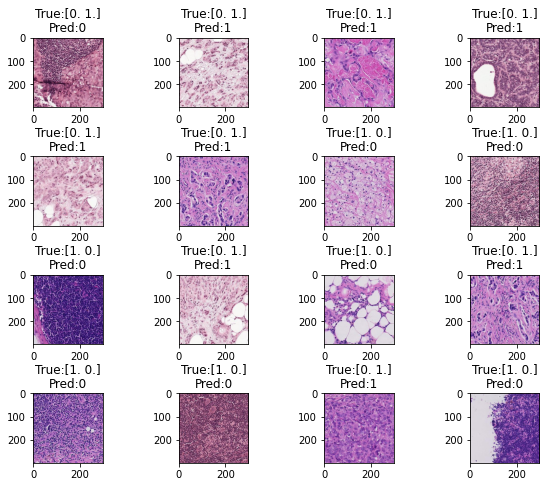

In [ ]:
def show_predictions(model, validation_generator, plotNum):
  data_batch, labels_batch = validation_generator.next()
  # fig, axs = plt.subplots(plotNum//4+1, 4)
  height = plotNum//4+1
  width = 4
  plt.figure(figsize=(10,10))
  for i in range(plotNum):
    image = data_batch[i]
    true_label = labels_batch[i]
    predict_label = np.argmax(model.predict(np.expand_dims(image,axis=0)),axis=-1)[0]
    plt.subplot(height,width, i+1)
    plt.imshow(image)
    plt.title('True:' + str(true_label) + '\n'
              'Pred:' + str(predict_label))
    plt.subplots_adjust(hspace = 0.7)

show_predictions(single_scale_inception_model_2, val_generator_single_scale,16)

#### Fine-tuning model

In [ ]:
## DONT FIX PARAMTERS: fine tuning

inception_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(PATCH_SIZE, PATCH_SIZE, 3))
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
single_scale_inception_model_2 = tf.keras.Sequential([
          inception_model,
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dropout(.5),
          tf.keras.layers.Dense(2, activation='softmax')
          ])


single_scale_inception_model_2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
                     # loss='categorical_crossentropy',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [ ]:
len(single_scale_inception_model_2.trainable_variables)

192

In [ ]:
single_scale_inception_model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 514       
Total params: 55,357,986
Trainable params: 55,323,554
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
history = single_scale_inception_model_2.fit(
    train_generator_single_scale, validation_data=val_generator_single_scale, epochs=20, callbacks = [callback])

In [ ]:
# save model
single_scale_inception_model_2.save(single_scale_inception_model_unfix_save)

# save history
hist_df = pd.DataFrame(history.history) 
hist_csv_file = single_scale_inception_model_unfix_history_save 
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
plot(history,single_scale_inception_model_unfix_plot_acc_save, single_scale_inception_model_unfix_plot_loss_save)

### Multiple Scale model

#### transfer learning model

In [ ]:
def initialize_inception_model(patch_size = PATCH_SIZE, trainable=False):
  inception_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(patch_size, patch_size, 3))
  inception_model.trainable = trainable
  return inception_model

In [ ]:
def multi_scale_model(model_1, model_2):
  # for each input image, the model consists of CNN model (except for the final flatten layer and dense layer) 
  # and a globalAvergaePooling2D
  input1 = model_1.input
  output1 = tf.keras.layers.GlobalAveragePooling2D()(model_1.output)
  
  # add a suffix to layers so that the layer name will not be duplicated
  for layer in model_2.layers:
    layer._name = layer._name + str("_two")
  input2 = model_2.input
  output2 = tf.keras.layers.GlobalAveragePooling2D()(model_2.output)  
  # concatenate the 2 output from CNN model and add a dense layer for predictions
  output = tf.keras.layers.Concatenate()([output1, output2])
  pred = tf.keras.layers.Dense(2, activation='softmax')(output)

  model = tf.keras.Model([input1, input2], outputs=pred)

  return model

In [ ]:
# CNN for both inputs is set to pretrained Inception. Could change to other models by changing the arg
multi_scale_inception_model = multi_scale_model(initialize_inception_model(),initialize_inception_model())
multi_scale_inception_model.compile(optimizer='adam',
              # loss='categorical_crossentropy',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
n_train_steps = len(train_generator_single_scale)
n_val_steps = len(val_generator_single_scale)
history = multi_scale_inception_model.fit(
    train_generator_two_scale, 
    steps_per_epoch=n_train_steps,
    validation_data=val_generator_two_scale, 
    validation_steps = n_val_steps,epochs=20,
    callbacks = [callback])

In [ ]:
# save model
multi_scale_inception_model.save(multi_scale_inception_model_fix_save)

# save history
hist_df = pd.DataFrame(history.history) 
hist_csv_file = multi_scale_inception_model_fix_history_save 
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
plot(history,multi_scale_inception_model_fix_plot_acc_save, multi_scale_inception_model_fix_plot_loss_save)

#### Fine-tuning model

In [ ]:
def multi_scale_model_2(model_1, model_2):
  # for each input image, the model consists of CNN model (except for the final flatten layer and dense layer) 
  input1 = model_1.input
  output1 = tf.keras.layers.Flatten()(model_1.output)
  # outout1 = tf.keras.layers.Dense(128, activation='relu')(output1)
  
  # add a suffix to layers so that the layer name will not be duplicated
  for layer in model_2.layers:
    layer._name = layer._name + str("_two")
  input2 = model_2.input
  output2 = tf.keras.layers.Flatten()(model_2.output) 
  # outout2 = tf.keras.layers.Dense(128, activation='relu')(output2) 
  # concatenate the 2 output from CNN model and add a dense layer for predictions
  output = tf.keras.layers.Concatenate()([output1, output2])
  outout = tf.keras.layers.Dense(256, activation='relu')(output)
  output = tf.keras.layers.Dropout(.6)(output)
  pred = tf.keras.layers.Dense(2, activation='softmax')(output)

  model = tf.keras.Model([input1, input2], outputs=pred)

  return model

In [ ]:
# CNN for both inputs is set to pretrained Inception. Could change to other models by changing the arg
multi_scale_inception_model_2 = multi_scale_model_2(initialize_inception_model(trainable=True),initialize_inception_model(trainable=True))
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
multi_scale_inception_model_2.compile(optimizer=optim,
              loss='categorical_crossentropy',
              # loss='binary_crossentropy',
              metrics=['accuracy'])

n_train_steps = len(train_generator_single_scale)
n_val_steps = len(val_generator_single_scale)
history = multi_scale_inception_model_2.fit(
    train_generator_two_scale, 
    steps_per_epoch=n_train_steps,
    validation_data=val_generator_two_scale, 
    validation_steps = n_val_steps,epochs=20,
    callbacks = [callback])

In [ ]:
# save model
multi_scale_inception_model_2.save(multi_scale_inception_model_unfix_save)

# save history
hist_df = pd.DataFrame(history.history) 
hist_csv_file = multi_scale_inception_model_unfix_history_save 
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
plot(history,multi_scale_inception_model_unfix_plot_acc_save, multi_scale_inception_model_unfix_plot_loss_save)

### Load back the final model's training plot

It is also in the video/slides.


In [ ]:
multi_scale_inception_model_unfix_save = result_save_dir + '/models/level12_multi_scale_inception_model_unfix.h5'
multi_scale_inception_model_unfix_plot_acc_save = result_save_dir + '/models/level12_multi_scale_inception_model_unfix_acc.png'
multi_scale_inception_model_unfix_plot_loss_save = result_save_dir + '/models/level12_multi_scale_inception_model_unfix_loss.png'

In [ ]:
multi_scale_inception_unfix_model = tf.keras.models.load_model(single_scale_inception_model_unfix_save)


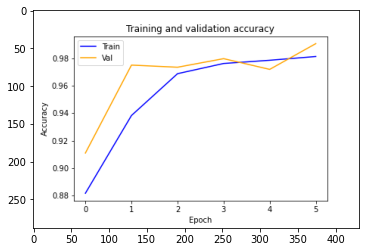

In [ ]:
acc_plot = plt.imread(multi_scale_inception_model_unfix_plot_acc_save)
plt.imshow(acc_plot)

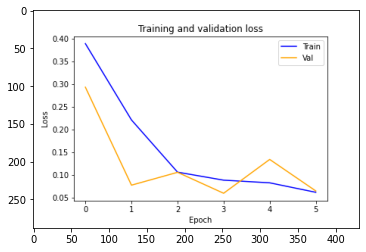

In [ ]:
loss_plot = plt.imread(multi_scale_inception_model_unfix_plot_loss_save)
plt.imshow(loss_plot)